In [11]:
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from einops import rearrange
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data as load_data_Fashion_MNIST
from tensorflow.keras.datasets.cifar10 import load_data as load_data_CIFAR_10

from nn.losses import *
from nn.layers import *
from nn.initializers import *
from nn.activations import *
from nn.network import NeuralNetwork, MulticlassNNClassifier

In [3]:
%load_ext autoreload

In [4]:
%autoreload

## Utility functions

In [9]:
def print_sizes(dataset):
    for subset in ['train', 'test']:
        for part in ['x', 'y']:
            print(f'{subset:>5} {part} - {dataset[subset][part].shape}')

In [10]:
def plot_random_images(images):
    chosen_images = random.choices(images, k=16)
    joined_image = rearrange(chosen_images, '(nh nw) h w c -> (nh h) (nw w) c', nw=4)
    cmap = 'gray' if images.shape[-1] == 1 else None
    plt.imshow(joined_image, cmap=cmap)

## Fashion MNIST

### Loading data

In [52]:
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = load_data_Fashion_MNIST()

fmnist = {
    'train': {
        'x': x_train_fmnist[..., np.newaxis] / 255.0,
        'y': y_train_fmnist
    },
    'test': {
        'x': x_test_fmnist[..., np.newaxis] / 255.0,
        'y': y_test_fmnist
    }
}

In [53]:
print_sizes(fmnist)

train x - (60000, 28, 28, 1)
train y - (60000,)
 test x - (10000, 28, 28, 1)
 test y - (10000,)


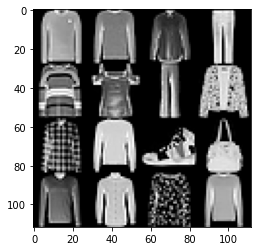

In [54]:
plot_random_images(fmnist['train']['x'])

### Tensorflow

### This library

## CIFAR 10

### Loading data

In [57]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = load_data_CIFAR_10()

cifar10 = {
    'train': {
        'x': x_train_cifar10 / 255,
        'y': y_train_cifar10
    },
    'test': {
        'x': x_test_cifar10 / 255,
        'y': y_test_cifar10
    }
}

In [38]:
print_sizes(cifar10)

train x - (50000, 32, 32, 3)
train y - (50000, 1)
 test x - (10000, 32, 32, 3)
 test y - (10000, 1)


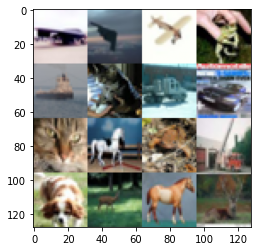

In [65]:
plot_random_images(cifar10['train']['x'])

### Tensorflow

### This library

## 20 class dataset

### Loading data

In [116]:
ds = tf.keras.utils.image_dataset_from_directory(
    'data/cars',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    seed=42,
    image_size=(224, 224),
)

x_cars, y_cars = zip(*ds)
x_cars = np.concatenate(x_cars).astype(int) / 255
y_cars = np.concatenate(y_cars)

x_train_cars, x_test_cars, y_train_cars, y_test_cars = train_test_split(
    x_cars,
    y_cars,
    test_size=0.20,
    random_state=42
)

cars = {
    'train': {
        'x': x_train_cars,
        'y': y_train_cars
    },
    'test': {
        'x': x_test_cars,
        'y': y_test_cars
    }
}

Found 3235 files belonging to 20 classes.


In [117]:
print_sizes(cars)

train x - (2588, 224, 224, 3)
train y - (2588,)
 test x - (647, 224, 224, 3)
 test y - (647,)


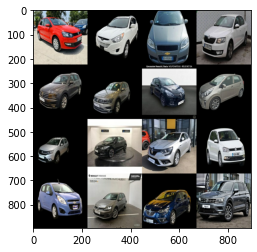

In [118]:
plot_random_images(cars['train']['x'])

### Tensorflow

### This library